# Assignment 1 Huirui Han 250833163

## Problem 1 Linear Heat Conduction
Solve for the one-dimensional temperature distribution in a square bar of mild steel as given below. The properties of mild steel are:

 - $k$ = 60 [W/m$\cdot$K]
 - $\rho$ = 7800 [kg/m$^3$]
 - $c_p$ = 430 [J/kg$\cdot$K]
 
Assume the convection coefficient is zero on the exposed surfaces, and fixed end temperatures of $T_1$ =100 [$^\circ$C] and $T_2$ = 0 [$^\circ$C].

In [1]:
import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""
    
    def __init__(self, lx, ly, lz, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            ly .... total length of domain in x-direction [m]
            lz .... total length of domain in x-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv
        
        # Calculate the control volume length
        dx = lx/float(ncv)
        
        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])
        
        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] + 
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])
        
        # Calculate face areas
        self._Af = ly*lz*np.ones(ncv+1)
        
        # Calculate the outer surface area for each cell
        self._Ao = (2.0*dx*ly + 2.0*dx*lz)*np.ones(ncv)
        
        # Calculate cell volumes
        self._vol = dx*ly*lz*np.ones(ncv)
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
    
    @property
    def xf(self):
        """Face location array"""
        return self._xf
    
    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP
    
    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]
        
    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]
      
    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]
    
    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]
    
    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao
    
    @property
    def vol(self):
        """Cell volume array"""
        return self._vol

In [2]:
class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """
    
    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)
        
    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)
        
    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP
        
    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE
        
    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
        
    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP
    
    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW
    
    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE
    
    @property
    def rP(self):
        """Cell residual"""
        return self._rP

In [3]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2

In [4]:
class DirichletBc:
    """Class defining a Dirichlet boundary condition"""
    
    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        return self._value
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 0
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")

In [5]:
class NeumannBc:
    """Class defining a Neumann boundary condition"""
    
    def __init__(self, phi, grid, gradient, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            gradient ... gradient at cell adjacent to boundary
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._gradient = gradient
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 1
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

In [6]:
class DiffusionModel:
    """Class defining a diffusion model"""
    
    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc
        
    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""
        
        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE
        
        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE
        
        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()
        
        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0
        
        # Calculate the net flux from each cell
        flux = flux_e - flux_w
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        
        # Return the modified coefficient array
        return coeffs

In [7]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2,dtype=int)
    cols = np.zeros(3*ncv-2,dtype=int)
    data[0] = coeffs.aP[0]
    data[1] = coeffs.aE[0]
    rows[0] = 0
    cols[0] = 0
    rows[1] = 0
    cols[1] = 1
    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
    data[3*ncv-4] = coeffs.aW[-1]
    data[3*ncv-3] = coeffs.aP[-1]
    rows[3*ncv-4:3*ncv-2] = ncv-1
    cols[3*ncv-4] = ncv-2
    cols[3*ncv-3] = ncv-1
    return csr_matrix((data, (rows, cols)))

def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)

In [8]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 0

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 100, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 30.0; Avg. Resid. = 3.0
Iteration = 1; Max. Resid. = 2.220446049250313e-15; Avg. Resid. = 8.881784197001252e-16


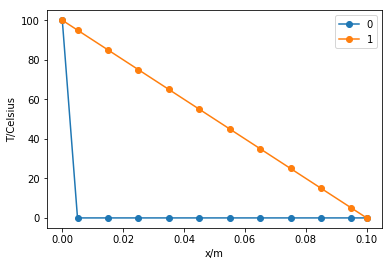

mid-point temperature is 50.0000


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i), marker='o')
    i += 1

plt.xlabel("x/m")
plt.ylabel("T/Celsius")
plt.legend()
plt.show()

Tr=(T_solns[-1][int(len(T_solns[-1])/2)])
Tl=(T_solns[-1][int((len(T_solns[-1])-1)/2)])
Tmid=0.5*(Tr+Tl)
print('mid-point temperature is %.4f' % Tmid)

In [10]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 0

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 100, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 60.0; Avg. Resid. = 3.0
Iteration = 1; Max. Resid. = 8.659739592076221e-15; Avg. Resid. = 1.3211653993039363e-15


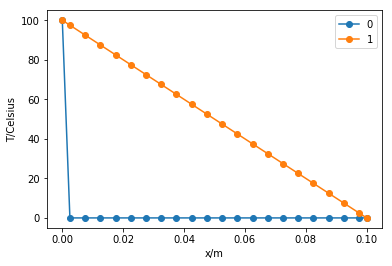

mid-point temperature is 50.0000


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i), marker='o')
    i += 1

plt.xlabel("x/m")
plt.ylabel("T/Celsius")
plt.legend()
plt.show()

Tr=(T_solns[-1][int(len(T_solns[-1])/2)])
Tl=(T_solns[-1][int((len(T_solns[-1])-1)/2)])
Tmid=0.5*(Tr+Tl)
print('mid-point temperature is %.4f' % Tmid)

In [12]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 30
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 0

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 100, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 89.99999999999999; Avg. Resid. = 2.9999999999999996
Iteration = 1; Max. Resid. = 1.2434497875801753e-14; Avg. Resid. = 2.55351295663786e-15


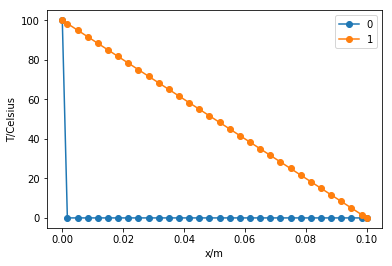

mid-point temperature is 50.0000


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i), marker='o')
    i += 1

plt.xlabel("x/m")
plt.ylabel("T/Celsius")
plt.legend()
plt.show()

Tr=(T_solns[-1][int(len(T_solns[-1])/2)])
Tl=(T_solns[-1][int((len(T_solns[-1])-1)/2)])
Tmid=0.5*(Tr+Tl)
print('mid-point temperature is %.4f' % Tmid)

### Grid Independence Test:

Control volume number    | Mid-point temperature/Celsius                                       | Difference %
:----------:| :--------------------------------------------------:|:---------------:
10       | 50.0000                 | N/A
20        | 50.0000 | 0
30        | 50.0000         | 0

### Comments on the result:



#### 1.For the grid independence test, almost no difference for ncv=10,20,30.

#### 2.For this problem, there is no convection. There is temperature gradient in the bar along x direction, so the energy transfer by conduction will occur in direction of decreasing temperature, just as the numerical solution shows.

## Problem2 External Convection
Consider the same geometry and properties as in problem 1, except use $h$ = 12 [W/m$^2\cdot$K] for the exposed surfaces of the bar, and end temperatures of $T_1$ = $T_2$ = 100 [$^\circ$C].  Assume the surrounding air to be at $T_{\infty}$ = 25 [$^\circ$C]. Obtain the solution for this problem and compare your solution to the analytical solution.


In [14]:
class SurfaceConvectionModel:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, ho, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._ho = ho
        self._To = To
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = self._ho*self._grid.Ao*(self._T[1:-1] - self._To)
        
        # Calculate the linearization coefficients
        coeffP = self._ho*self._grid.Ao
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [15]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 25

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 100

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 100, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 100, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 0.18000000000000002; Avg. Resid. = 0.18
Iteration = 1; Max. Resid. = 2.525757381022231e-15; Avg. Resid. = 1.2823075934420559e-15


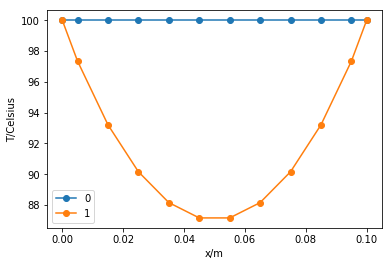

mid-point temperature is 87.1647


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i), marker='o')
    i += 1

plt.plot()
plt.xlabel("x/m")
plt.ylabel("T/Celsius")
plt.legend()
plt.show()

Tr=(T_solns[-1][int(len(T_solns[-1])/2)])
Tl=(T_solns[-1][int((len(T_solns[-1])-1)/2)])
Tmid=0.5*(Tr+Tl)
print('mid-point temperature is %.4f' % Tmid)

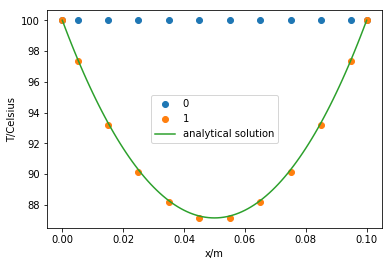

The minimum temperature is 87.1647


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i), marker='o', linestyle='None')
    i += 1
# Analytical solution

P=2*ly+2*lz
Ac=ly*lz
m=(ho*P/k/Ac)**0.5
T1=100
T2=100
theta0=T1-To
thetaL=T2-To
x =np.array([lx/100*i for i in range(101)])
theta=theta0*(thetaL/theta0*np.sinh(m*x)+np.sinh(m*(lx-x)))/np.sinh(m*lx)
Ta=theta+To
plt.plot(x, Ta, label='analytical solution')

plt.xlabel("x/m")
plt.ylabel("T/Celsius")
plt.legend()
plt.show()
Tr=(T_solns[-1][int(len(T_solns[-1])/2)])
Tl=(T_solns[-1][int((len(T_solns[-1])-1)/2)])
Tmid=0.5*(Tr+Tl)
print('The minimum temperature is %.4f' % min(T))

In [18]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 25

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 100

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 100, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 100, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 0.09000000000000001; Avg. Resid. = 0.09000000000000002
Iteration = 1; Max. Resid. = 5.981326545168031e-15; Avg. Resid. = 2.1295465391091282e-15


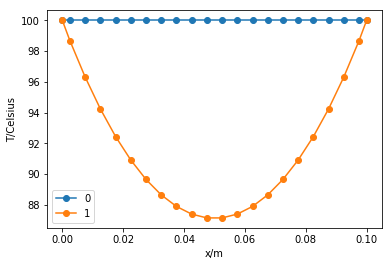

mid-point temperature is 87.1538


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i), marker='o')
    i += 1

plt.xlabel("x/m")
plt.ylabel("T/Celsius")
plt.legend()
plt.show()

Tr=(T_solns[-1][int(len(T_solns[-1])/2)])
Tl=(T_solns[-1][int((len(T_solns[-1])-1)/2)])
Tmid=0.5*(Tr+Tl)
print('mid-point temperature is %.4f' % Tmid)

In [20]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 30
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 25

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 100

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 100, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 100, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 0.060000000000000005; Avg. Resid. = 0.06000000000000002
Iteration = 1; Max. Resid. = 8.76382300063483e-15; Avg. Resid. = 2.5717853772514824e-15


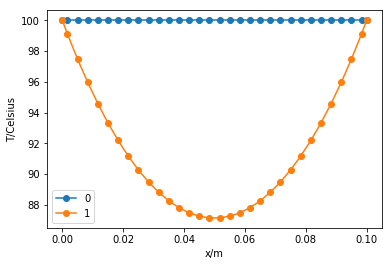

mid-point temperature is 87.1517


In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i), marker='o')
    i += 1

plt.xlabel("x/m")
plt.ylabel("T/Celsius")
plt.legend()
plt.show()

Tr=(T_solns[-1][int(len(T_solns[-1])/2)])
Tl=(T_solns[-1][int((len(T_solns[-1])-1)/2)])
Tmid=0.5*(Tr+Tl)
print('mid-point temperature is %.4f' % Tmid)

### Grid Independent Test:



Control volume number    | Midpoint temperature/Celsius                                         | Difference/%
:----------:| :--------------------------------------------------------:|:---------------:
10       |  87.1647                | N/A
20        | 87.1538 | -0.0125
30        | 87.1517          | -0.0024

### Comments on the result:

#### 1. For grid independent test, there is little difference for ncv=10,20,30. Thus, ncv=10 is used for comparing with the analytical result.Like the figure at the end of ncv=10 shows, the analytical solution for the domain and the numerical solution for the domain is almost same.

#### 2. This problem involves the external convection. The temperature of the air outside the bar is below the end temperatures. Thus, the convection heat transfer will happen between the bar and air. Sine the two end temperatures are the same, the minimum temperature within the bar should be at around the middle point of the bar along the x direction. Compare the analytical and numerical result of ncv=10, the midpoint is exactly the minimum value of the temperature.

## Problem 3 - Internal Heat Generation

A plane wall $L$ = 0.1 [m] thick with a thermal conductivity of $k$ = 26 [W/m$\cdot$K] is exposed to an environment at an ambient temperature of 50 [$^\circ$C] on one side and an environment of 40 [$^\circ$C] on the other side. The convection coefficient at the exposed surfaces is estimated to be $h$ = 280 [W/m$^2\cdot$K]. If heat is generated uniformly within the wall at a rate 50,000 [W/m$^3$], determine the surface temperatures of the walls, and the location and value of the maximum temperature inside the wall. Compare your result to the analytical result, which can be obtained from a heat transfer textbook.

In [22]:
class RobinBc:
    """Class defining a Robin boundary condition"""
    
    def __init__(self, phi, grid, To, loc,ho,k):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._To = To
        self._loc = loc
        self._ho = ho
        self._k = k
        
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return (self._phi[1] + (self._ho/self._k)*self._grid.dx_WP[0]*self._To)/(1 + self._grid.dx_WP[0]*(self._ho/self._k))
        elif self._loc is BoundaryLocation.EAST:
            return (self._phi[-2] + (self._ho/self._k)*self._grid.dx_PE[-1]*self._To)/(1+ self._grid.dx_PE[-1]*(self._ho/self._k))
        else:
            raise ValueError("Unknown boundary location")
    
    def coeff(self):
        """Return the linearization coefficient"""
        if self._loc is BoundaryLocation.WEST:
            return 1/(1 + self._grid.dx_WP[0]*(self._ho/self._k))
        elif self._loc is BoundaryLocation.EAST:
            return 1/(1+ self._grid.dx_PE[-1]*(self._ho/self._k))
        else:
            raise ValueError("Unknown boundary location")
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = (self._phi[1] + (self._ho/self._k)*self._grid.dx_WP[0]*self._To)/(1 + self._grid.dx_WP[0]*(self._ho/self._k))
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = (self._phi[-2] + (self._ho/self._k)*self._grid.dx_PE[-1]*self._To)/(1 + self._grid.dx_PE[-1]*(self._ho/self._k))
        else:
            raise ValueError("Unknown boundary location")

In [23]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2, dtype=int)
    cols = np.zeros(3*ncv-2, dtype=int)
    data[0] = coeffs.aP[0]
    data[1] = coeffs.aE[0]
    rows[0] = 0
    cols[0] = 0
    rows[1] = 0
    cols[1] = 1
    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
    data[3*ncv-4] = coeffs.aW[-1]
    data[3*ncv-3] = coeffs.aP[-1]
    rows[3*ncv-4:3*ncv-2] = ncv-1
    cols[3*ncv-4] = ncv-2
    cols[3*ncv-3] = ncv-1
    return csr_matrix((data, (rows, cols)))

def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)

In [24]:
class InternalGenerationModel:
    """Class defining a internal generation model"""
    
    def __init__(self, grid, T, s):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._s = s

        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source =  -self._s*self._grid.vol
        
        # Calculate the linearization coefficients
        coeffP = 0
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [25]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 1
lz = 1
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 26

# Define convection and internal generation parameters
ho = 280
T1= 50
T2 = 40
s=50000
# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 45

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = RobinBc(T, grid, T1, BoundaryLocation.WEST,ho,k)
east_bc = RobinBc(T, grid, T2, BoundaryLocation.EAST,ho,k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
internalsource = InternalGenerationModel(grid, T, s)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = internalsource.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 1613.295880149883; Avg. Resid. = 361.32958801498455
Iteration = 1; Max. Resid. = 9.367795428261161e-11; Avg. Resid. = 2.4148505417542764e-11


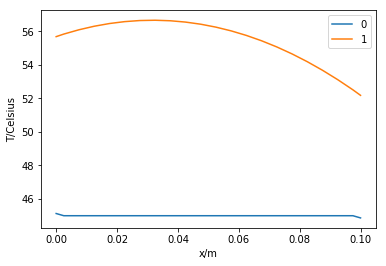

the surface temperatures are 55.6786,52.1786
the maximum temperature is 56.6565, the corresponding location is x = 0.0650


In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x/m")
plt.ylabel("T/Celsius")
plt.legend()
plt.show()
Lx=0.1
ncv=10
Tmax=max(T)
Tmax_index=list(T).index(Tmax)
Tmax_loc=(Tmax_index-1)*Lx/ncv+0.5*Lx/ncv
print('the surface temperatures are %.4f,%.4f' % (T[0],T[-1]))
print('the maximum temperature is %.4f, the corresponding location is x = %.4f' % (Tmax,Tmax_loc))

In [27]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 1
lz = 1
ncv = 40
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 26

# Define convection and internal generation parameters
ho = 280
T1= 50
T2 = 40
s=50000
# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 45

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = RobinBc(T, grid, T1, BoundaryLocation.WEST,ho,k)
east_bc = RobinBc(T, grid, T2, BoundaryLocation.EAST,ho,k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
internalsource = InternalGenerationModel(grid, T, s)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = internalsource.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 1506.404174572981; Avg. Resid. = 187.82020872864902
Iteration = 1; Max. Resid. = 1.0385292625869624e-10; Avg. Resid. = 4.339426595834084e-11


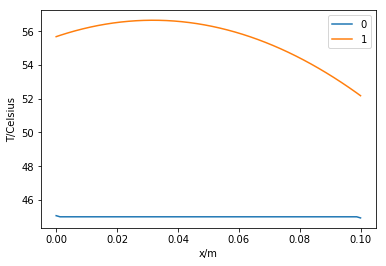

the surface temperatures are 55.6786,52.1786
the maximum temperature is 56.6521, the corresponding location is x = 0.1250


In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x/m")
plt.ylabel("T/Celsius")
plt.legend()
plt.show()
Lx=0.1
ncv=10
Tmax=max(T)
Tmax_index=list(T).index(Tmax)
Tmax_loc=(Tmax_index-1)*Lx/ncv+0.5*Lx/ncv
print('the surface temperatures are %.4f,%.4f' % (T[0],T[-1]))
print('the maximum temperature is %.4f, the corresponding location is x = %.4f' % (Tmax,Tmax_loc))

In [29]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 1
lz = 1
ncv = 60
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 26

# Define convection and internal generation parameters
ho = 280
T1= 50
T2 = 40
s=50000
# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 45

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = RobinBc(T, grid, T1, BoundaryLocation.WEST,ho,k)
east_bc = RobinBc(T, grid, T2, BoundaryLocation.EAST,ho,k)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
internalsource = InternalGenerationModel(grid, T, s)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = internalsource.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 1470.8809826345675; Avg. Resid. = 126.80714386559694
Iteration = 1; Max. Resid. = 2.2797053134127054e-10; Avg. Resid. = 6.389152910439103e-11


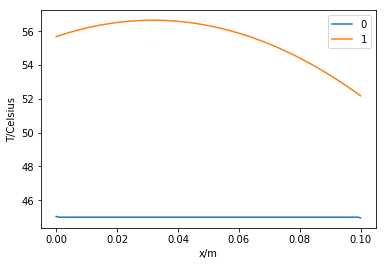

the surface temperatures are 55.6786,52.1786
the maximum temperature is 56.6511, the corresponding location is x = 0.1950


In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x/m")
plt.ylabel("T/Celsius")
plt.legend()
plt.show()
Lx=0.1
ncv=10
Tmax=max(T)
Tmax_index=list(T).index(Tmax)
Tmax_loc=(Tmax_index-1)*Lx/ncv+0.5*Lx/ncv
print('the surface temperatures are %.4f,%.4f' % (T[0],T[-1]))
print('the maximum temperature is %.4f, the corresponding location is x = %.4f' % (Tmax,Tmax_loc))

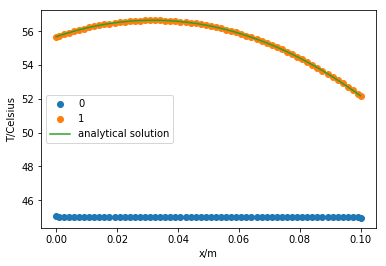

the surface temperatures are 55.6786,52.1786
The maximum temperature is 56.6511


In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i), marker = 'o', linestyle = 'None')
    i += 1
# Analytical solution
T1=50
T2=40
C1=((s * ho * lx ** 2 + 2 * s * lx * k - 2 * T1 * ho * k + 2 * ho * T2 * k) / k / (ho * lx + 2 * k)) / 0.2e1
C2=((s * ho * lx ** 2 + 2 * lx * T1 * ho ** 2 + 2 * s * lx * k + 2 * T1 * ho * k + 2 * ho * T2 * k) / (ho * lx + 2 * k) / ho) / 0.2e1
x =np.array([lx/60*i for i in range(61)])
Ta=-s*x**2/2/k+C1*x+C2
plt.plot(x, Ta, label='analytical solution')
plt.xlabel("x/m")
plt.ylabel("T/Celsius")
plt.legend()
plt.show()
print('the surface temperatures are %.4f,%.4f' % (T[0],T[-1]))
print('The maximum temperature is %.4f' % max(T))

### Grid Independent Test:

Control Volume Number    | Maximum temperature inside the wall/Celsius                                         | Difference/%
:----------:| :--------------------------------------------------:|:---------------:
20       | 56.6565                 | N/A
40        | 56.6521 | -0.0078
60        | 56.6511         | -0.0018

### Comments on the result:

#### 1. For the grid independent test, there is little difference. ncv=60 is used to compare with the analytical solution. Like the figure at the end of ncv-60 shows, the  analytical solution and numerical solution is almost same. 

#### 2.  Since there is heat generation in the wall, the temperature within the wall will not vary linearly with x, which is exactly shown in the plotted figure. Based on the results, it is also seen that the maximum temperature also happens not at the wall surfaces because of the heat generation within the wall.

## Problem 4 - Radiation 

Solve the following problem using the square bar geometry given in question 1 with $T_\infty$ = 0 [K]. Assume that the convection coefficient is $h$ = 0 [W/m$^2\cdot$K], the emmisivity is $\epsilon$ = 1.0, the end temperatures are $T_1$ = 400 [K] and $T_2$ = 0 [K]. Try solving this problem using the following linearizations of the radiation source term:

- Apply $q_o^{\prime\prime} = \epsilon \sigma (T^4 - T_\infty^4)$ into the residual and do not include any contribution from this term into the Jacobian matrix. This is an explicit implementation of the source term.
- Apply $q_o^{\prime\prime} = \epsilon \sigma (T^4 - T_\infty^4)$ into the residual and include the linearizaton $\partial q_o^{\prime\prime}/\partial T$ into the Jacobian matrix. This is an implicit implementation of the source term.

Solve using each linearization assuming the material is:

- Steel, for which: $k$ = 60 [W/m$\cdot$K], $c_p$ = 430 [J/kg$\cdot$K]
- Wood, for which: $k$ = 0.1 [W/m$\cdot$K], $c_p$ = 1.3 [J/kg$\cdot$K]

Explain any differences that you observe.

## Explict STEEL

In [32]:
class RadiationModel:
    """Class defining a radiation model"""
    
    def __init__(self, grid, T, epsilon, To,s):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._epsilon = epsilon
        self._To = To
        self._s = s
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = self._epsilon*self._grid.Ao*s*(self._T[1:-1]**4 - self._To**4)
        
        # Calculate the linearization coefficients
        # coeffP = self._ho*self._grid.Ao
        
        # Add to coefficient arrays
        coeffs.accumulate_rP(source)
        
        return coeffs

In [33]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60
epsilon = 1.0
To = 0
s = 5.670367e-8

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 100

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

radiation = RadiationModel(grid, T, epsilon, To,s)
# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = radiation.add(coeffs)
    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 89.9988659266; Avg. Resid. = 12.000907258719996
Iteration = 1; Max. Resid. = 0.23528860933335302; Avg. Resid. = 0.05683437708688506
Iteration = 2; Max. Resid. = 0.005537049039200853; Avg. Resid. = 0.0019420267483440691
Iteration = 3; Max. Resid. = 0.00021395619308620106; Avg. Resid. = 7.732714833396771e-05
Iteration = 4; Max. Resid. = 8.68244185578404e-06; Avg. Resid. = 3.178615729771701e-06
Iteration = 5; Max. Resid. = 3.578224326561408e-07; Avg. Resid. = 1.3146955591929147e-07


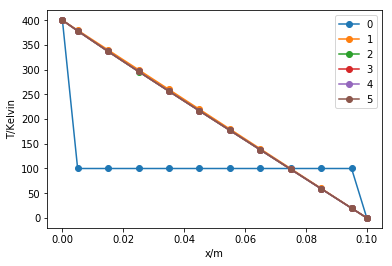

mid-point temperature is 196.9806


In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i), marker='o')
    i += 1

plt.xlabel("x/m")
plt.ylabel("T/Kelvin")
plt.legend()
plt.show()

Tr=(T_solns[-1][int(len(T_solns[-1])/2)])
Tl=(T_solns[-1][int((len(T_solns[-1])-1)/2)])
Tmid=0.5*(Tr+Tl)
print('mid-point temperature is %.4f' % Tmid)

In [35]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60
epsilon = 1.0
To = 0
s = 5.670367e-8

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 100

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

radiation = RadiationModel(grid, T, epsilon, To,s)
# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = radiation.add(coeffs)
    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 179.9994329633; Avg. Resid. = 12.000510333029998
Iteration = 1; Max. Resid. = 0.130600843540774; Avg. Resid. = 0.028615215021504093
Iteration = 2; Max. Resid. = 0.0026394245075116174; Avg. Resid. = 0.0009199998160511187
Iteration = 3; Max. Resid. = 0.00010232461365293488; Avg. Resid. = 3.6449917986998716e-05
Iteration = 4; Max. Resid. = 4.1317795411166536e-06; Avg. Resid. = 1.4842892518171888e-06
Iteration = 5; Max. Resid. = 1.6862093991931726e-07; Avg. Resid. = 6.071146681346265e-08


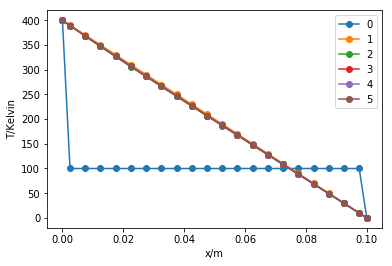

mid-point temperature is 197.0037


In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i), marker='o')
    i += 1

plt.xlabel("x/m")
plt.ylabel("T/Kelvin")
plt.legend()
plt.show()

Tr=(T_solns[-1][int(len(T_solns[-1])/2)])
Tl=(T_solns[-1][int((len(T_solns[-1])-1)/2)])
Tmid=0.5*(Tr+Tl)
print('mid-point temperature is %.4f' % Tmid)

In [37]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60
epsilon = 1.0
To = 0
s = 5.670367e-8

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 100

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

radiation = RadiationModel(grid, T, epsilon, To,s)
# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = radiation.add(coeffs)
    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 179.9994329633; Avg. Resid. = 12.000510333029998
Iteration = 1; Max. Resid. = 0.130600843540774; Avg. Resid. = 0.028615215021504093
Iteration = 2; Max. Resid. = 0.0026394245075116174; Avg. Resid. = 0.0009199998160511187
Iteration = 3; Max. Resid. = 0.00010232461365293488; Avg. Resid. = 3.6449917986998716e-05
Iteration = 4; Max. Resid. = 4.1317795411166536e-06; Avg. Resid. = 1.4842892518171888e-06
Iteration = 5; Max. Resid. = 1.6862093991931726e-07; Avg. Resid. = 6.071146681346265e-08


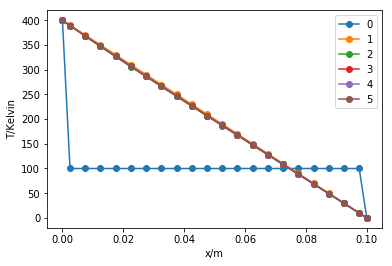

mid-point temperature is 197.0037


In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i), marker='o')
    i += 1

plt.xlabel("x/m")
plt.ylabel("T/Kelvin")
plt.legend()
plt.show()

Tr=(T_solns[-1][int(len(T_solns[-1])/2)])
Tl=(T_solns[-1][int((len(T_solns[-1])-1)/2)])
Tmid=0.5*(Tr+Tl)
print('mid-point temperature is %.4f' % Tmid)

### Grid Independent Test:

Control Volume Number    | Midpoint Temperature/Kelvin                                         | Difference/%
:----------:| :--------------------------------------------------:|:---------------:
10       | 196.9806                | N/A
20        |197.0037 | 0.0117
30        | 197.0037          | 0

## IMPLICIT STEEL

In [39]:
class RadiationModel:
    """Class defining a radiation model"""
    
    def __init__(self, grid, T, epsilon, To,s):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._epsilon = epsilon
        self._To = To
        self._s = s
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = self._epsilon*self._grid.Ao*s*(self._T[1:-1]**4 - self._To**4)
        
        # Calculate the linearization coefficients
        coeffP = 4*self._epsilon*self._grid.Ao*s*(self._T[1:-1]**3 )
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [40]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60
epsilon = 1.0
To = 0
s = 5.670367e-8

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 100

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

radiation = RadiationModel(grid, T, epsilon, To,s)
# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = radiation.add(coeffs)
    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 89.9988659266; Avg. Resid. = 12.000907258719996
Iteration = 1; Max. Resid. = 0.22228199930683892; Avg. Resid. = 0.05169195806549761
Iteration = 2; Max. Resid. = 6.15173030626831e-05; Avg. Resid. = 2.2577843462478793e-05
Iteration = 3; Max. Resid. = 2.390551645525818e-11; Avg. Resid. = 8.646615726250725e-12


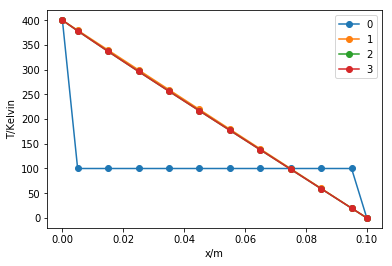

mid-point temperature is 196.9805


In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i), marker='o')
    i += 1

plt.xlabel("x/m")
plt.ylabel("T/Kelvin")
plt.legend()
plt.show()

Tr=(T_solns[-1][int(len(T_solns[-1])/2)])
Tl=(T_solns[-1][int((len(T_solns[-1])-1)/2)])
Tmid=0.5*(Tr+Tl)
print('mid-point temperature is %.4f' % Tmid)

In [42]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60
epsilon = 1.0
To = 0
s = 5.670367e-8

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 100

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

radiation = RadiationModel(grid, T, epsilon, To,s)
# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = radiation.add(coeffs)
    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 179.9994329633; Avg. Resid. = 12.000510333029998
Iteration = 1; Max. Resid. = 0.12394037780049855; Avg. Resid. = 0.026030692655571085
Iteration = 2; Max. Resid. = 3.0292039890661426e-05; Avg. Resid. = 1.0615701364338402e-05
Iteration = 3; Max. Resid. = 1.07046663200272e-11; Avg. Resid. = 3.8734039221829975e-12


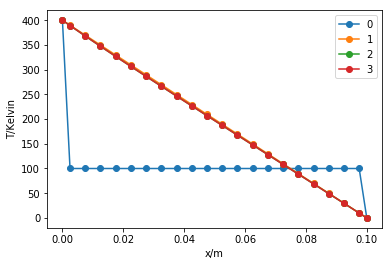

mid-point temperature is 197.0037


In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i), marker='o')
    i += 1

plt.xlabel("x/m")
plt.ylabel("T/Kelvin")
plt.legend()
plt.show()

Tr=(T_solns[-1][int(len(T_solns[-1])/2)])
Tl=(T_solns[-1][int((len(T_solns[-1])-1)/2)])
Tmid=0.5*(Tr+Tl)
print('mid-point temperature is %.4f' % Tmid)

In [44]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 30
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60
epsilon = 1.0
To = 0
s = 5.670367e-8

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 100

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

radiation = RadiationModel(grid, T, epsilon, To,s)
# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = radiation.add(coeffs)
    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 269.99962197553333; Avg. Resid. = 12.000352822835563
Iteration = 1; Max. Resid. = 0.0856250286408476; Avg. Resid. = 0.017376638954329268
Iteration = 2; Max. Resid. = 2.0074699630306947e-05; Avg. Resid. = 6.99956292142388e-06
Iteration = 3; Max. Resid. = 6.983996714282625e-12; Avg. Resid. = 2.530192699390408e-12


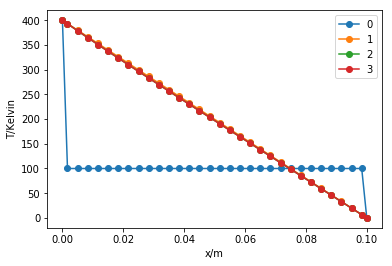

mid-point temperature is 197.0080


In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i), marker='o')
    i += 1

plt.xlabel("x/m")
plt.ylabel("T/Kelvin")
plt.legend()
plt.show()

Tr=(T_solns[-1][int(len(T_solns[-1])/2)])
Tl=(T_solns[-1][int((len(T_solns[-1])-1)/2)])
Tmid=0.5*(Tr+Tl)
print('mid-point temperature is %.4f' % Tmid)

### Grid Independent Test:

Control Volume Number    | Midpoint Temperature/Kelvin                                         | Difference/%
:----------:| :--------------------------------------------------:|:---------------:
10       | 196.9805                | N/A
20        |197.0037 | 0.0118
30        | 197.0080          | 0.0022

## Explicit Wood

In [46]:
class RadiationModel:
    """Class defining a radiation model"""
    
    def __init__(self, grid, T, epsilon, To,s):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._epsilon = epsilon
        self._To = To
        self._s = s
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = self._epsilon*self._grid.Ao*s*(self._T[1:-1]**4 - self._To**4)
        
        # Calculate the linearization coefficients
        # coeffP = self._ho*self._grid.Ao
        
        # Add to coefficient arrays
        coeffs.accumulate_rP(source)
        
        return coeffs

In [47]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 0.1
epsilon= 1.0
To=0
s = 5.670367e-8

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 100

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

radiation = RadiationModel(grid, T, epsilon, To,s)
# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = radiation.add(coeffs)
    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 0.1488659266; Avg. Resid. = 0.020907258719999995
Iteration = 1; Max. Resid. = 0.20834554802078709; Avg. Resid. = 0.03930827497494352
Iteration = 2; Max. Resid. = 14.02725657008389; Avg. Resid. = 4.609276391915644
Iteration = 3; Max. Resid. = 115852568695.89038; Avg. Resid. = 38719357082.04213
Iteration = 4; Max. Resid. = 8.682799840545964e+50; Avg. Resid. = 2.842194314720381e+50
Iteration = 5; Max. Resid. = 2.95509374269721e+210; Avg. Resid. = 9.38232127071259e+209
Iteration = 6; Max. Resid. = inf; Avg. Resid. = inf
Iteration = 7; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 8; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 9; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 10; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 11; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 12; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 13; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 14; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 15; Max. Resid. 

C:\Users\hanhu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in power
  app.launch_new_instance()


## IMPLICIT WOOD

In [48]:
class RadiationModel:
    """Class defining a radiation model"""
    
    def __init__(self, grid, T, epsilon, To,s):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._epsilon = epsilon
        self._To = To
        self._s = s
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = self._epsilon*self._grid.Ao*s*(self._T[1:-1]**4 - self._To**4)
        
        # Calculate the linearization coefficients
        coeffP = 4*self._epsilon*self._grid.Ao*s*(self._T[1:-1]**3 )
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [49]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 0.1
epsilon = 1.0
To = 0
s = 5.670367e-8

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 100

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

radiation = RadiationModel(grid, T, epsilon, To,s)
# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = radiation.add(coeffs)
    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 0.1488659266; Avg. Resid. = 0.020907258719999995
Iteration = 1; Max. Resid. = 0.1258235410305612; Avg. Resid. = 0.017189712590485677
Iteration = 2; Max. Resid. = 0.02177535224150303; Avg. Resid. = 0.0032679803944868366
Iteration = 3; Max. Resid. = 0.0011973932721156197; Avg. Resid. = 0.0002484968884332832
Iteration = 4; Max. Resid. = 9.605940703765956e-06; Avg. Resid. = 2.55652782670131e-06
Iteration = 5; Max. Resid. = 1.5218443345788035e-09; Avg. Resid. = 4.892884766876855e-10


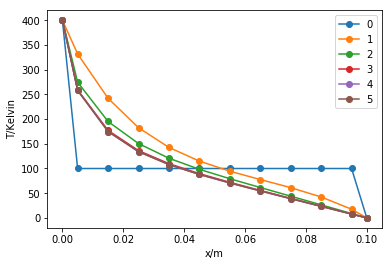

mid-point temperature is 79.3709


In [50]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i), marker='o')
    i += 1

plt.xlabel("x/m")
plt.ylabel("T/Kelvin")
plt.legend()
plt.show()

Tr=(T_solns[-1][int(len(T_solns[-1])/2)])
Tl=(T_solns[-1][int((len(T_solns[-1])-1)/2)])
Tmid=0.5*(Tr+Tl)
print('mid-point temperature is %.4f' % Tmid)

In [51]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 0.1
epsilon = 1.0
To = 0
s = 5.670367e-8

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 100

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

radiation = RadiationModel(grid, T, epsilon, To,s)
# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = radiation.add(coeffs)
    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 0.29943296329999997; Avg. Resid. = 0.020510333029999998
Iteration = 1; Max. Resid. = 0.09443753377433656; Avg. Resid. = 0.009574483155414827
Iteration = 2; Max. Resid. = 0.009534733936970751; Avg. Resid. = 0.0015529288720543119
Iteration = 3; Max. Resid. = 0.0005922004247856695; Avg. Resid. = 0.00011224640074242488
Iteration = 4; Max. Resid. = 5.273194724209063e-06; Avg. Resid. = 1.3456399174771687e-06
Iteration = 5; Max. Resid. = 9.77097638042712e-10; Avg. Resid. = 3.1807999988155787e-10


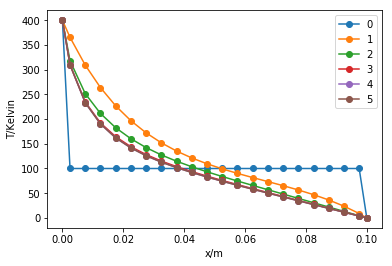

mid-point temperature is 78.5615


In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i), marker='o')
    i += 1

plt.xlabel("x/m")
plt.ylabel("T/Kelvin")
plt.legend()
plt.show()

Tr=(T_solns[-1][int(len(T_solns[-1])/2)])
Tl=(T_solns[-1][int((len(T_solns[-1])-1)/2)])
Tmid=0.5*(Tr+Tl)
print('mid-point temperature is %.4f' % Tmid)

In [53]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 30
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 0.1
epsilon = 1.0
To = 0
s = 5.670367e-8

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 100

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

radiation = RadiationModel(grid, T, epsilon, To,s)
# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = radiation.add(coeffs)
    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 0.4496219755333333; Avg. Resid. = 0.020352822835555565
Iteration = 1; Max. Resid. = 0.07165750772227428; Avg. Resid. = 0.006515831079092814
Iteration = 2; Max. Resid. = 0.0070949181416525495; Avg. Resid. = 0.0009890220674892835
Iteration = 3; Max. Resid. = 0.00039187991468573637; Avg. Resid. = 7.344555296492374e-05
Iteration = 4; Max. Resid. = 3.472185507490469e-06; Avg. Resid. = 9.003116242059245e-07
Iteration = 5; Max. Resid. = 6.720349255383284e-10; Avg. Resid. = 2.1707946728908933e-10


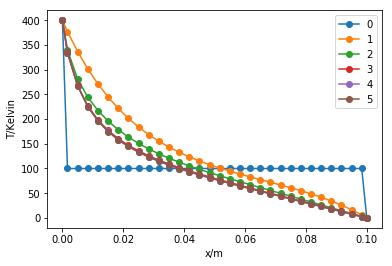

mid-point temperature is 78.4192


In [54]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i), marker='o')
    i += 1

plt.xlabel("x/m")
plt.ylabel("T/Kelvin")
plt.legend()
plt.show()

Tr=(T_solns[-1][int(len(T_solns[-1])/2)])
Tl=(T_solns[-1][int((len(T_solns[-1])-1)/2)])
Tmid=0.5*(Tr+Tl)
print('mid-point temperature is %.4f' % Tmid)

### Grid Independent Test:

Control Volume Number    | Midpoint Temperature/Kelvin                                         | Difference/%
:----------:| :--------------------------------------------------:|:---------------:
10       | 79.3709               | N/A
20        |78.5615 | -1.0198
30        | 78.4192          | -0.1811

### Comments on the result:

#### 1. For the grid independent test, there is little difference, either ncv number can be used for the numercal simulation.

#### 2. The explicit method for the steel is converged and the explicit method for the wood is diverged. In terms of the thermal conductivity,  the steel is much higher that wood's.  Since the radiation heat flux is only contribnuted in source term of the residual,with the same emmisivity, if the thermal conductivity is higher enough , the convergence mainly depends on the diffusion term. But for small theraml conductivity,  the influence of the radiation in the source term will be higher than the conduction.Under this condition, if we don't change the linearization coefficients in the Jacobian matrix, the residual of the source term will accumulate, which may cause divergence. That's why we get converged solution for the steel while diverged solution for the wood.

#### 3. The implicit method for both the steel and wood is converged. Since in this method,  the linearization coefficients is included in the Jacobian matrix. The source term residual will be modified by the linearization coefficients after each iteration. Thus, the value of the thermal conductivity will not influence the solution.  

#### 4. Compare the iteration numbers of the steel for the explicit and implicit method, it can be seen that the iterations for the implicit method is less because of the residual reduction by the included linearization coefficient